# Experiment 1
Use a simple sentence transformer to compute the semantic textual similarity as measured by the cosine similarity. The average cosine similarity will be used.
Steps:
- get corpus of junior resumes
- calculate embeddings
- calculate embeddings of the senior swe job description
- calculate cosine similarity of every resume and the job description


In [1]:
import os
import logging
from transformers import AutoTokenizer, AutoModel
import torch
import re

# Load the SBERT model and tokenizer
model_name = 'sentence-transformers/paraphrase-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [87]:
# step get junior resume corpus
junior_resume_dir = "/Users/andreasloutzidis/Downloads/indeed_data/SWE_junior_le_2years_txt/"
jd_swe_senior_dir = "/Users/andreasloutzidis/Downloads/indeed_data/jd_SWE_senior/"

with open(jd_swe_senior_dir + "jd_1.txt", "r") as file:
    jd_swe_senior = file.read()
job_description = jd_swe_senior
job_description = job_description.replace("\n", "")

In [88]:
# create embeddigns for the job description
jd_length = len(job_description)
window_size = 2800
if jd_length > window_size:
    jd_chunks = []
    jd_chunks.append(job_description[:int(jd_length/2)])
    jd_chunks.append(job_description[int(jd_length/2):])
else:
    jd_chunks.append(job_description)
embeddings_jd = []
for chunk in jd_chunks:
    encoded_chunk = tokenizer(chunk, return_tensors='pt')
    embeddings_jd.append(model(**encoded_chunk).last_hidden_state.mean(dim=1))

In [89]:
# create embeddings from the resumes
embeddings_res = []
window_size = 2000
for filename in os.listdir(junior_resume_dir):
    if filename.endswith(".txt"):
        input_file_path = os.path.join(junior_resume_dir, filename)
        with open(input_file_path, "r", encoding="utf-8") as file:
            file_contents = file.read()
            res_chunks = []
            if len(file_contents) > window_size:
                res_length = len(file_contents)
                res_chunks.append(file_contents[:int(res_length/2)])
                res_chunks.append(file_contents[int(res_length/2):])
                
            else:
                res_chunks.append(file_contents)
            for chunk in res_chunks:
                encoded_res = tokenizer(chunk, return_tensors='pt')
                try:
                    embeddings_res.append(model(**encoded_res).last_hidden_state.mean(dim=1))
                except:
                    logging.error(f"filename: {filename}, size: {len(file_contents)}")
                    logging.error(f"filename: {filename}, size: {len(chunk)}")

In [90]:
# no calculate the average cosine similarity
similarities = []
for i in range(len(embeddings_jd)):
    for j in range(len(embeddings_res)):
        cos_sim = torch.nn.functional.cosine_similarity(embeddings_jd[i], embeddings_res[j])
        similarities.append(cos_sim.item())

# take the average of the cosine similarities as the final similarity score
final_similarity = sum(similarities) / len(similarities)
print(f"Average cosine similarity is: {final_similarity}")

Average cosine similarity is: 0.5697355410084128


### now create a function for this

In [148]:
len(clean_text(job_description))

3108

In [15]:
# create text cleaning
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove special characters and symbols
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Convert to lowercase
    text = text.lower()

    return text

def get_cosine_similarity(resume_dir, job_description_path, res_window, jd_window):
    with open(job_description_path, "r") as file:
        job_description = file.read()
    job_description = job_description.replace("\n", "")
    # create embeddigns for the job description
    jd_length = len(job_description)
    jd_chunks = []
    if jd_length > jd_window:
        jd_chunks.append(job_description[:int(jd_length/2)])
        jd_chunks.append(job_description[int(jd_length/2):])
    else:
        jd_chunks.append(job_description)
    embeddings_jd = []
    for chunk in jd_chunks:
        chunk = clean_text(chunk)
        encoded_chunk = tokenizer(chunk, return_tensors='pt')
        embeddings_jd.append(model(**encoded_chunk).last_hidden_state.mean(dim=1))

    # create embeddings from the resumes
    embeddings_res = []
    for filename in os.listdir(resume_dir):
        if filename.endswith(".txt"):
            input_file_path = os.path.join(resume_dir, filename)
            with open(input_file_path, "r", encoding="utf-8") as file:
                file_contents = file.read()
                res_chunks = []
                res_length = len(file_contents)
                if res_length > res_window:
                    res_chunks.append(file_contents[:int(res_length/2)])
                    res_chunks.append(file_contents[int(res_length/2):])

                else:
                    res_chunks.append(file_contents)
                for chunk in res_chunks:
                    chunk = clean_text(chunk)
                    encoded_res = tokenizer(chunk, return_tensors='pt')
                    try:
                        embeddings_res.append(model(**encoded_res).last_hidden_state.mean(dim=1))
                    except:
                        logging.error(f"filename: {filename}, size: {len(file_contents)}")
                        logging.error(f"filename: {filename}, size: {len(chunk)}")

    # no calculate the average cosine similarity
    similarities = []
    for i in range(len(embeddings_jd)):
        for j in range(len(embeddings_res)):
            cos_sim = torch.nn.functional.cosine_similarity(embeddings_jd[i], embeddings_res[j])
            similarities.append(cos_sim.item())

    # take the average of the cosine similarities as the final similarity score
    final_similarity = sum(similarities) / len(similarities)
    print(f"Average cosine similarity is: {final_similarity:.04f}")
    return

In [2]:
data_path = "/Users/andreasloutzidis/Downloads/indeed_data"
# senior_jd = os.path.join(data_path, "jd_SWE_senior", "jd_1.txt")
senior_jd = os.path.join(data_path, "jd_SWE_senior", "senior_swe_comcast.txt")
junior_resume_dir = os.path.join(data_path, "SWE_junior_le_2years_txt/")
mid_resume_dir = os.path.join(data_path, "SWE_mid_ge_3years_le_5years_txt")
senior_resume_dir = os.path.join(data_path, "SWE_senior_ge_6years_txt/")
frontend_junior_resume_dir = os.path.join(data_path, "frontend_junior_txt")
frontend_mid_resume_dir = os.path.join(data_path, "frontend_mid_txt")

input_resume_dir = frontend_mid_resume_dir
get_cosine_similarity(
    resume_dir=input_resume_dir,
    job_description_path=senior_jd,
    jd_window=2800,
    res_window=2600
)


# Results
jd_1.txt
- senior jd w junior applicants
    - Average cosine similarity is: 0.5844338263571263
- senior jd w mid applicants
    - Average cosine similarity is: 0.5919555368575644
- senior jd w senior applicants
    - Average cosine similarity is: 0.5698464676164664
- junior frontnend
    - Average cosine similarity is: 0.5933
- mid frontend
    - Average cosine similarity is: 0.5903


senior_swe_comcast.txt
- senior jd w junior applicants
    - Average cosine similarity is: 0.6502
- senior jd w mid applicants
    - Average cosine similarity is: 0.6611
- senior jd w senior applicants
    - Average cosine similarity is: 0.6742

- junior frontnend
    - Average cosine similarity is: 0.6472

- mid frontend
    - Average cosine similarity is: 0.6706




### Takeaways:
- cosine similarity cannot distinguish between senior and junior resumes


# calculate records number and average length

In [171]:
def calc_dir_details(input_dir):
    input_dir_complete = os.path.join(data_path, input_dir)
    avg_length = 0
    count = 0
    for filename in os.listdir(input_dir_complete):
        if filename.endswith(".txt"):
            input_file_path = os.path.join(input_dir_complete, filename)
            with open(input_file_path, "r", encoding="utf-8") as file:
                file_contents = file.read()
                avg_length += len(file_contents)
                count += 1
    avg_length = int(avg_length / count)
    print(f"dir: {input_dir}, files: {count}, avg length: {avg_length}")

In [175]:
calc_dir_details("SWE_junior_le_2years_txt")
calc_dir_details("SWE_mid_ge_3years_le_5years_txt")
calc_dir_details("SWE_senior_ge_6years_txt")
calc_dir_details("frontend_junior_txt")
calc_dir_details("frontend_mid_txt")

dir: SWE_junior_le_2years_txt, files: 38, avg length: 2012
dir: SWE_mid_ge_3years_le_5years_txt, files: 43, avg length: 2180
dir: SWE_senior_ge_6years_txt, files: 32, avg length: 2303
dir: frontend_junior_txt, files: 30, avg length: 1972
dir: frontend_mid_txt, files: 47, avg length: 2082


# Experiment 2 datascience job descriptions

In [14]:
jd_path = "/Users/andreasloutzidis/Downloads/jobLLMatch/Datasets/job_descriptions/data_scientist_txt"
data_path = "/Users/andreasloutzidis/Downloads/indeed_data"

# senior_jd = os.path.join(data_path, "jd_SWE_senior", "jd_1.txt")
senior_jd = os.path.join(data_path, "jd_SWE_senior", "senior_swe_comcast.txt")
junior_resume_dir = os.path.join(data_path, "SWE_junior_le_2years_txt/")
mid_resume_dir = os.path.join(data_path, "SWE_mid_ge_3years_le_5years_txt")
senior_resume_dir = os.path.join(data_path, "SWE_senior_ge_6years_txt/")
frontend_junior_resume_dir = os.path.join(data_path, "frontend_junior_txt")
frontend_mid_resume_dir = os.path.join(data_path, "frontend_mid_txt")


# now we have a list of job descriptions ANDF a list of resumes.
# Calculate the avg cosine siomilarity among all resumes and job descriptions

avg_cosine_similarity = []
for jd in os.listdir(jd_path):
    if jd.endswith(".txt"):
        cos_sim = get_cosine_similarity(
                    resume_dir=junior_resume_dir,
                    job_description_path=os.path.join(jd_path, jd),
                    jd_window=2000,
                    res_window=2000
                    )
        avg_cosine_similarity.append(cos_sim)
print(f"Average cos similarity across all jd and resume: {sum(avg_cosine_similarity)/len(avg_cosine_similarity):.02f}")


Average cosine similarity is: 0.5557
Average cosine similarity is: 0.5775
Average cosine similarity is: 0.5836
Average cosine similarity is: 0.5610


RuntimeError: The size of tensor a (624) must match the size of tensor b (512) at non-singleton dimension 1

# Cleaning the raw txt resume dataset

In [64]:
input_dir = "/Users/andreasloutzidis/Downloads/indeed_data/final_dataset/resume/resume_unity_txt"
output_dir = "/Users/andreasloutzidis/Downloads/indeed_data/final_dataset/resume/resume_unity_clean"

In [63]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove special characters and symbols
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Convert to lowercase
    text = text.lower()

    return text

def clean_directory(input_dir, output_dir):
    avg_length = 0
    count = 0
    lengths_list = []
    file_length_dict = {}
    for filename in os.listdir(input_dir):
        if filename.endswith(".txt"):
            input_file_path = os.path.join(input_dir, filename)
            with open(input_file_path, "r", encoding="utf-8") as file:
                file_contents = file.read()

            clean_txt = clean_text(file_contents)
            avg_length += len(clean_txt)
            lengths_list.append(len(clean_txt))
            count += 1
            output_file_path = os.path.join(output_dir, filename)
            with open(output_file_path, "w", encoding="utf-8") as file:
                file.write(clean_txt)
            
            # create a dictionary that contains the filename and the length of the file
            # this is useful for later analysis
            file_length_dict[filename] = len(clean_txt)
    avg_length = int(avg_length / count)
    # print(f"dir: {input_dir}, files: {count}, avg length: {avg_length}")

    return {
        "avg_length": avg_length,
        "count": count,
        "lengths_list": lengths_list
    }, file_length_dict



In [65]:
results, file_length_dict = clean_directory(input_dir, output_dir)

Number of resumes: 2861

Average length of resumes: 4740

Min length of resumes: 329

Max length of resumes: 31815

Median length of resumes: 3817.0

Standard deviation of resumes: 3407.5648806015683



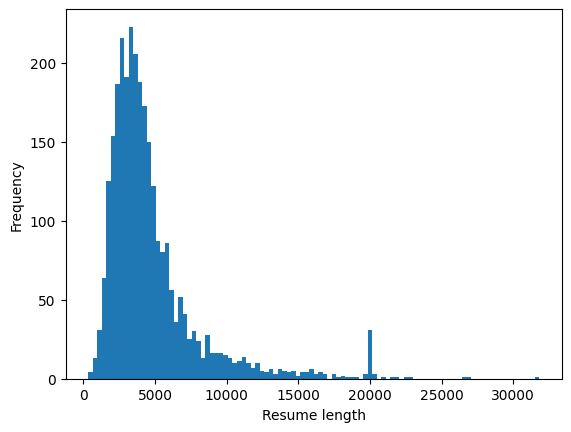

In [80]:
import numpy as np
import matplotlib.pyplot as plt

median = np.median(results['lengths_list'])
std = np.std(results['lengths_list'])

print(f"Number of resumes: {results['count']}\n")
print(f"Average length of resumes: {results['avg_length']}\n")
print(f"Min length of resumes: {min(results['lengths_list'])}\n")
print(f"Max length of resumes: {max(results['lengths_list'])}\n")
print(f"Median length of resumes: {np.median(results['lengths_list'])}\n")
print(f"Standard deviation of resumes: {np.std(results['lengths_list'])}\n")

# create a histogram of the lengths of the resumes
plt.hist(results['lengths_list'], bins=100)
plt.xlabel("Resume length")
plt.ylabel("Frequency")
plt.savefig("resume_length_histogram_raw.png")
plt.show()

Number of norm resumes: 2480

Average length of norm resumes: 3678

Min length of norm resumes: 545

Max length of norm resumes: 7216

Median length of norm resumes: 3537.5

Standard deviation of norm resumes: 1414.749976320491



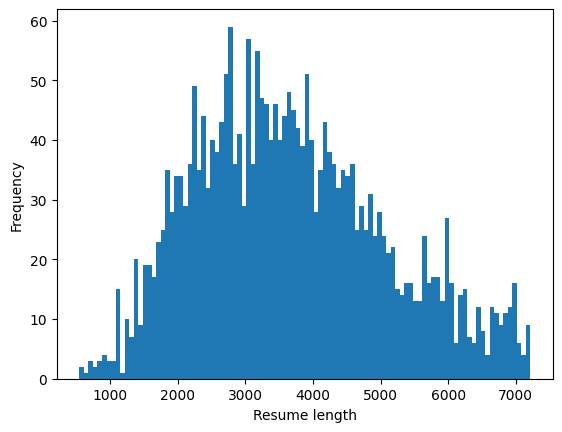

In [82]:
# normalizing resume. transfer resumes outside -std, +std to a new directory

input_dir = "/Users/andreasloutzidis/Downloads/indeed_data/final_dataset/resume/resume_unity_clean"
norm_output_dir = "/Users/andreasloutzidis/Downloads/indeed_data/final_dataset/resume/resume_unity_norm"
norm_count = 0
norm_lengths_list = []

for filename in os.listdir(input_dir):
    if filename.endswith(".txt"):
        if file_length_dict[filename] < (median - std) or file_length_dict[filename] > (median + std):
            continue
        else:
            norm_count += 1
            norm_lengths_list.append(file_length_dict[filename])
            input_file_path = os.path.join(input_dir, filename)
            with open(input_file_path, "r", encoding="utf-8") as file:
                file_contents = file.read()
            output_file_path = os.path.join(norm_output_dir, filename)
            with open(output_file_path, "w", encoding="utf-8") as file:
                file.write(file_contents)
            
print(f"Number of norm resumes: {norm_count}\n")
print(f"Average length of norm resumes: {int(np.mean(norm_lengths_list))}\n")
print(f"Min length of norm resumes: {min(norm_lengths_list)}\n")
print(f"Max length of norm resumes: {max(norm_lengths_list)}\n")
print(f"Median length of norm resumes: {np.median(norm_lengths_list)}\n")
print(f"Standard deviation of norm resumes: {np.std(norm_lengths_list)}\n")

# create a histogram of the lengths of the resumes
import matplotlib.pyplot as plt
plt.hist(norm_lengths_list, bins=100)
plt.xlabel("Resume length")
plt.ylabel("Frequency")
plt.savefig("resume_length_histogram_norm.png")
plt.show()

    

# Data statistics
BEFORE PROCESSING
- Number of resumes: 2861
- Average length of resumes: 4740
- Min length of resumes: 329
- Max length of resumes: 31815
- Median length of resumes: 3817.0
- Standard deviation of resumes: 3407.5648806015683
- Variance of resumes: 11611498.41550918

AFTER NORMALIZING
- Number of norm resumes: 2480
- Average length of norm resumes: 3678
- Min length of norm resumes: 545
- Max length of norm resumes: 7216
- Median length of norm resumes: 3537.5
- Standard deviation of norm resumes: 1414.749976320491

# Job description Cleaing

In [91]:
jd_raw = "/Users/andreasloutzidis/Downloads/indeed_data/final_dataset/job_descr/jd_unity_raw"
jd_clean = "/Users/andreasloutzidis/Downloads/indeed_data/final_dataset/job_descr/jd_unity_clean"

In [92]:
jd_results, jd_file_length_dict = clean_directory(jd_raw, jd_clean)

Number of job descriptions: 103

Average length of job descriptions: 2148

Min length of job descriptions: 529

Max length of job descriptions: 4992

Median length of job descriptions: 1975.0

Standard deviation of job descriptions: 910.3147719718323



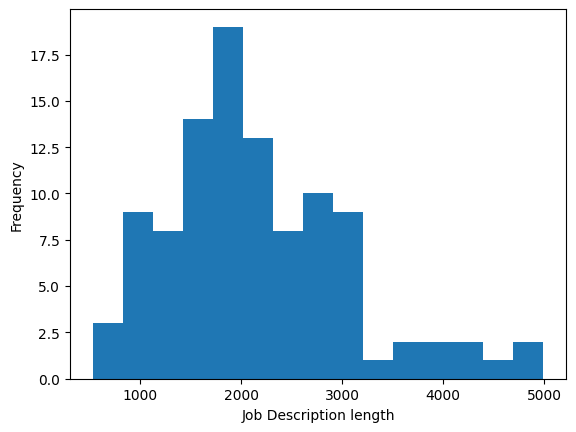

In [93]:
import numpy as np
import matplotlib.pyplot as plt

median = np.median(jd_results['lengths_list'])
std = np.std(jd_results['lengths_list'])

print(f"Number of job descriptions: {jd_results['count']}\n")
print(f"Average length of job descriptions: {jd_results['avg_length']}\n")
print(f"Min length of job descriptions: {min(jd_results['lengths_list'])}\n")
print(f"Max length of job descriptions: {max(jd_results['lengths_list'])}\n")
print(f"Median length of job descriptions: {np.median(jd_results['lengths_list'])}\n")
print(f"Standard deviation of job descriptions: {np.std(jd_results['lengths_list'])}\n")

# create a histogram of the lengths of the resumes
plt.hist(jd_results['lengths_list'], bins=15)
plt.xlabel("Job Description length")
plt.ylabel("Frequency")
plt.savefig("job_descr_histogram_raw.png")
plt.show()

Number of norm job descriptions: 96

Average length of norm job descriptions: 1986

Min length of norm job descriptions: 529

Max length of norm job descriptions: 3586

Median length of norm job descriptions: 1935.5

Standard deviation of norm job descriptions: 700.8180598532639



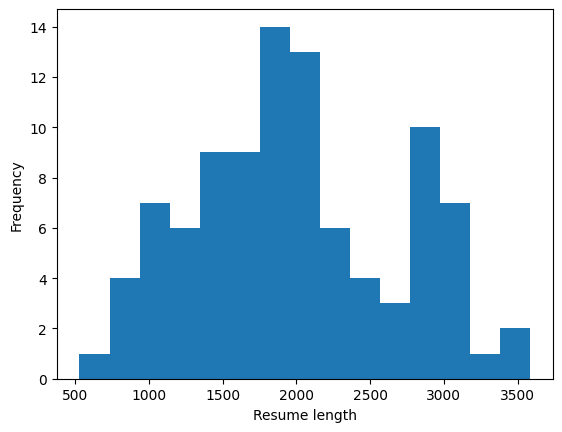

In [94]:
# normalizing resume. transfer resumes outside -std, +std to a new directory

input_dir = jd_clean
norm_output_dir = "/Users/andreasloutzidis/Downloads/indeed_data/final_dataset/job_descr/jd_unity_norm"
jd_norm_count = 0
jd_norm_lengths_list = []

for filename in os.listdir(input_dir):
    if filename.endswith(".txt"):
        if jd_file_length_dict[filename] < (median - 2*std) or jd_file_length_dict[filename] > (median + 2*std):
            continue
        else:
            jd_norm_count += 1
            jd_norm_lengths_list.append(jd_file_length_dict[filename])
            input_file_path = os.path.join(input_dir, filename)
            with open(input_file_path, "r", encoding="utf-8") as file:
                file_contents = file.read()
            output_file_path = os.path.join(norm_output_dir, filename)
            with open(output_file_path, "w", encoding="utf-8") as file:
                file.write(file_contents)
            
print(f"Number of norm job descriptions: {jd_norm_count}\n")
print(f"Average length of norm job descriptions: {int(np.mean(jd_norm_lengths_list))}\n")
print(f"Min length of norm job descriptions: {min(jd_norm_lengths_list)}\n")
print(f"Max length of norm job descriptions: {max(jd_norm_lengths_list)}\n")
print(f"Median length of norm job descriptions: {np.median(jd_norm_lengths_list)}\n")
print(f"Standard deviation of norm job descriptions: {np.std(jd_norm_lengths_list)}\n")

# create a histogram of the lengths of the resumes
import matplotlib.pyplot as plt
plt.hist(jd_norm_lengths_list, bins=15)
plt.xlabel("Resume length")
plt.ylabel("Frequency")
plt.savefig("job_descr_histogram_norm.png")
plt.show()

    

# Results statistics Job descriptions

JOB DESCRIPTIONS (CLEAN)
- Number of job descriptions: 103
- Average length of job descriptions: 2148
- Min length of job descriptions: 529
- Max length of job descriptions: 4992
- Median length of job descriptions: 1975.0
- Standard deviation of job descriptions: 910.3147719718323

JOB DESCRIPTIONS (NORM)
- Number of norm job descriptions: 96
- Average length of norm job descriptions: 1986
- Min length of norm job descriptions: 529
- Max length of norm job descriptions: 3586
- Median length of norm job descriptions: 1935.5
- Standard deviation of norm job descriptions: 700.8180598532639

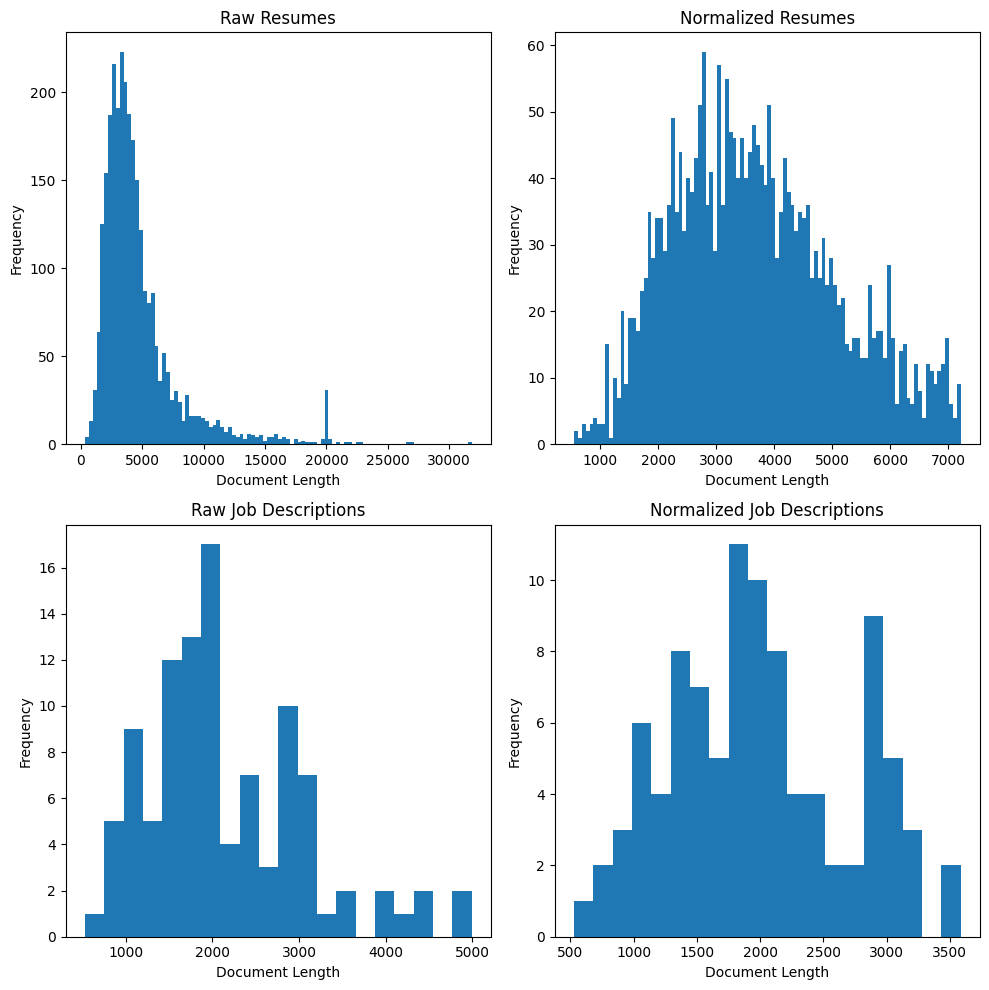

In [96]:
# # diagram 1
# # create a histogram of the lengths of the resumes
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].hist(results['lengths_list'], bins=100)
# axs[0].set_xlabel("Resume length")
# axs[0].set_ylabel("Frequency")
# axs[0].set_title("Raw Resumes")

# # diagram 2
# axs[1].hist(norm_lengths_list, bins=100)
# axs[1].set_xlabel("Resume length")
# axs[1].set_ylabel("Frequency")
# axs[1].set_title("Normalized Resumes")

# # plt.savefig("resume_length_histogram_combined.png")
# plt.show()

# create a histogram of the lengths of the resumes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# diagram 1
axs[0, 0].hist(results['lengths_list'], bins=100)
axs[0, 0].set_xlabel("Document Length")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].set_title("Raw Resumes")

# diagram 2
axs[0, 1].hist(norm_lengths_list, bins=100)
axs[0, 1].set_xlabel("Document Length")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].set_title("Normalized Resumes")

# diagram 3
axs[1, 0].hist(jd_results['lengths_list'], bins=20)
axs[1, 0].set_xlabel("Document Length")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].set_title("Raw Job Descriptions")

# diagram 4
axs[1, 1].hist(jd_norm_lengths_list, bins=20)
axs[1, 1].set_xlabel("Document Length")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_title("Normalized Job Descriptions")

plt.tight_layout()
plt.savefig("combined_histograms.png")
plt.show()
    